In [1]:
import numpy as np 
import pandas as pd
import folium
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.interpolate import CubicSpline
from folium.plugins import MarkerCluster
import xml.etree.ElementTree as ET
import traci
from deap import base, creator, tools, algorithms
import math
import random


In [2]:
file_path = r"C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\Fraizer street\ITSC\speed\Frazier_01082024_02052024\Frazier_01082024_02052024.csv"
file_path2 = r"C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\Fraizer street\ITSC\speed\Frazier_01082024_02052024\XD_Identification.csv"

df = pd.read_csv(file_path)
df_metadata =pd.read_csv(file_path2)

In [45]:
# Create a map centered at the mean latitude and longitude
map_center = [df_metadata['start_latitude'].mean(), df_metadata['start_longitude'].mean()]
mymap = folium.Map(location=map_center, zoom_start=5)

# Add a marker for each start point
marker_cluster = MarkerCluster().add_to(mymap)
for _, row in df_metadata.iterrows():
    folium.Marker(
        location=[row['start_latitude'], row['start_longitude']],
        popup=f"xd_id: {row['xd_id']}",
        icon=folium.Icon(color='blue')
    ).add_to(marker_cluster)

# Display the map
mymap

In [3]:
df = pd.merge(df, df_metadata[['intersection','xd_id', 'miles', 'start_longitude','end_longitude', 'start_latitude','end_latitude', ]], on='xd_id')
df.drop(columns=['xd_id'], inplace=True)

sorted_df = df.sort_values(by=['intersection', 'measurement_tstamp'])

# Filter rows with confidence_score equal to 30.0
#sorted_df = sorted_df[sorted_df['confidence_score'] == 30.0]
# Find the index of 'measurement_tstamp' column
measurement_tstamp_index = df.columns.get_loc('measurement_tstamp')
df.insert(measurement_tstamp_index + 1, 'intersection', df.pop('intersection'))

sorted_df['measurement_tstamp'] = pd.to_datetime(sorted_df['measurement_tstamp'])
sorted_df['day_of_week'] = sorted_df['measurement_tstamp'].dt.day_name()
sorted_df['day_type'] = sorted_df['day_of_week'].map(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')
sorted_df['measurement_tstamp'] = pd.to_datetime(sorted_df['measurement_tstamp'])


# Separate date and time into two columns
sorted_df['date'] = sorted_df['measurement_tstamp'].dt.date
sorted_df['timestamp'] = sorted_df['measurement_tstamp'].dt.time

#grouped_averages = sorted_df.groupby(['xd_id', 'day_type', 'timestamp'])['average_speed'].mean().reset_index()

grouped_averages = sorted_df.groupby(['intersection', 'day_type', 'timestamp']).agg({'speed': 'mean','travel_time_seconds':'mean' }).reset_index()
grouped_averages['speed (m/sec)']= grouped_averages['speed'] * 0.44704 

# Filter data for weekdays and weekends
weekday_data = grouped_averages[grouped_averages['day_type'] == 'Weekday']
weekend_data = grouped_averages[grouped_averages['day_type'] == 'Weekend']

# Filter data for weekdays and weekends
speed_calibration_weekday = grouped_averages[(grouped_averages['intersection'] == 'Market E') & (grouped_averages['day_type'] == 'Weekday')].reset_index()
speed_calibration_weekend =  grouped_averages[(grouped_averages['intersection'] == 'Market E') & (grouped_averages['day_type'] == 'Weekend')].reset_index()



# Create a new column 'speed_calibration_weekday'
speed_calibration_weekday['step_time_sec'] = np.arange(0, 14401, 300)


# Assuming 'day_type' contains values 'weekday' and 'weekend'
# Also assuming 'intersection' column contains names of intersections

# Filter data for the intersection 'Market E' and separate into weekday and weekend
market_e_data = grouped_averages[grouped_averages['intersection'] == 'Market E']

weekday_data_market_e = market_e_data[market_e_data['day_type'] == 'Weekday'].copy()
weekend_data_market_e = market_e_data[market_e_data['day_type'] == 'Weekend'].copy()

weekday_data_market_e['step_time_sec'] = np.arange(0, 14401, 300)
weekend_data_market_e['step_time_sec'] = np.arange(0, 14401, 300)

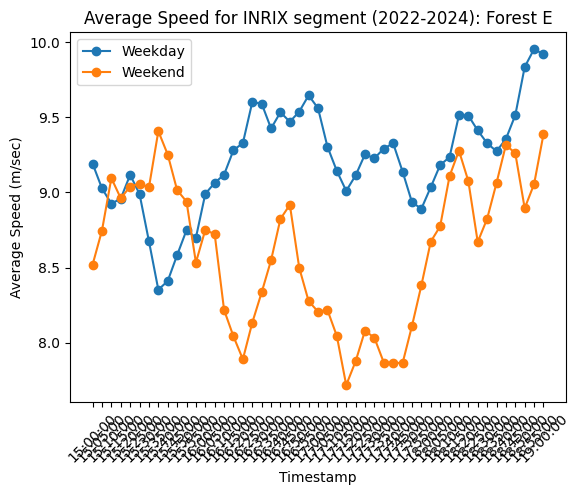

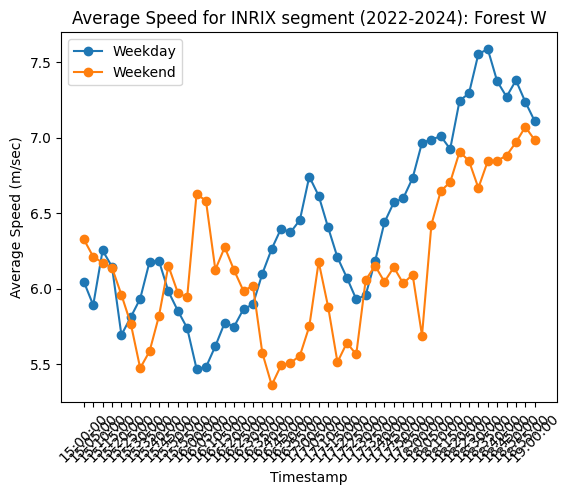

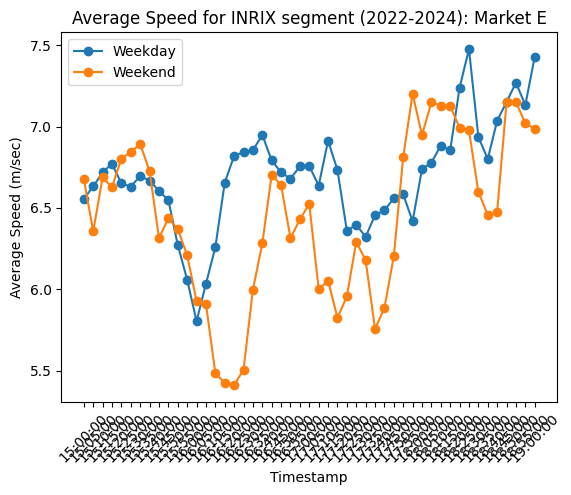

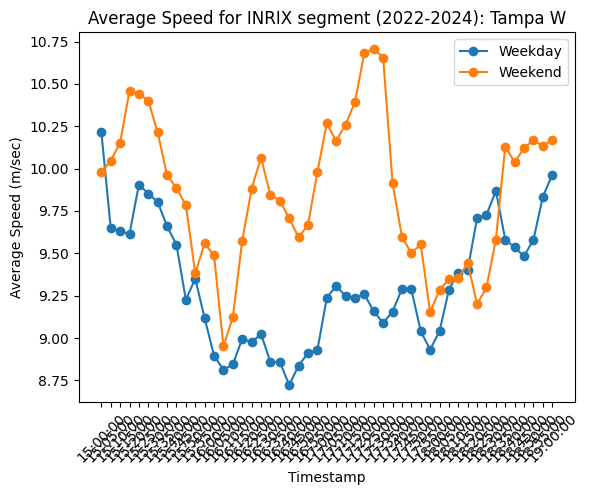

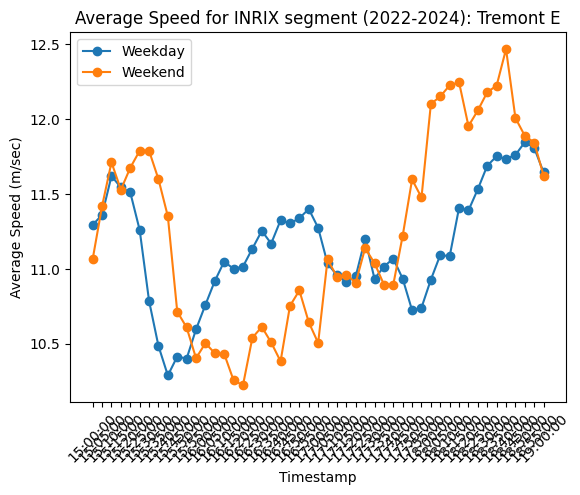

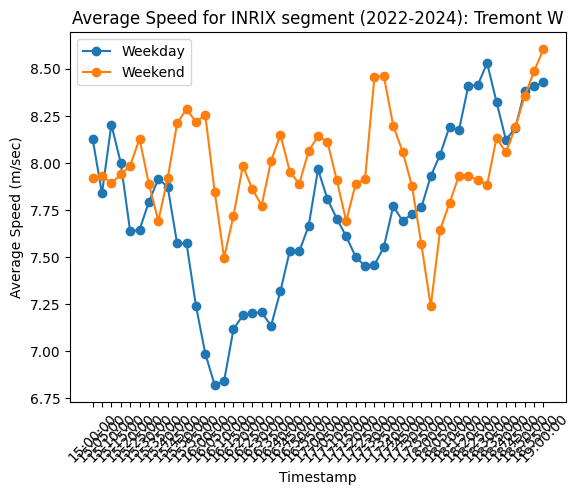

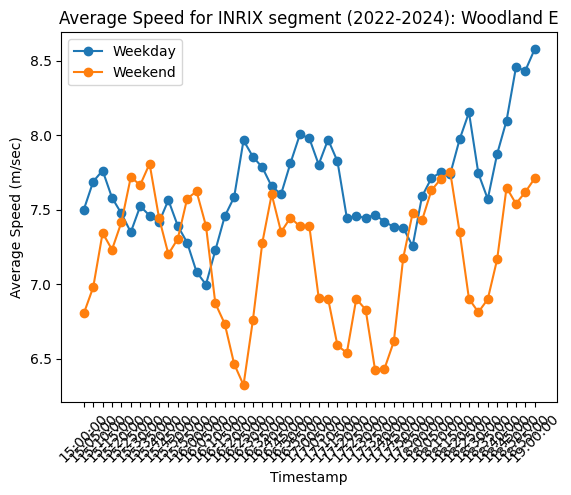

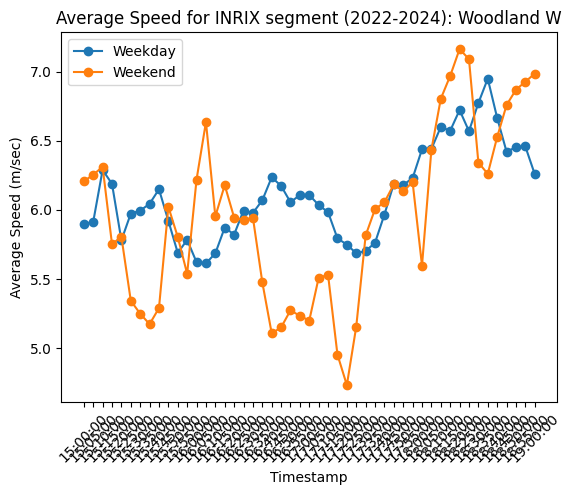

In [408]:

grouped_averages['timestamp'] = grouped_averages['timestamp'].astype(str)

for intersection, group_data in grouped_averages.groupby('intersection'):
    fig, ax = plt.subplots()
    for day_type, data in group_data.groupby('day_type'):
        # Plot data points without interpolation
        ax.plot(data['timestamp'], data['speed (m/sec)'], label=day_type, marker='o')
        
    ax.set_title(f'Average Speed for INRIX segment (2022-2024): {intersection}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Average Speed (m/sec)')
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()



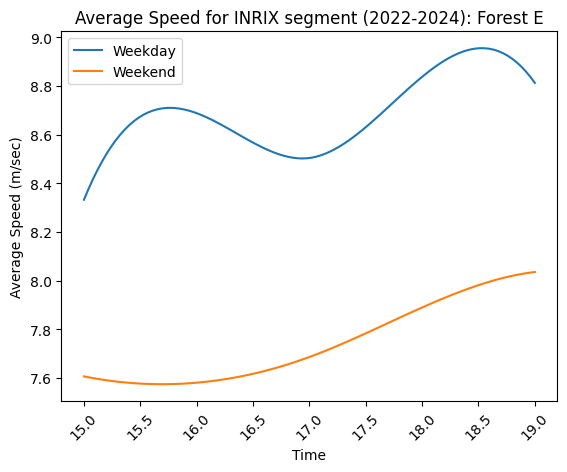

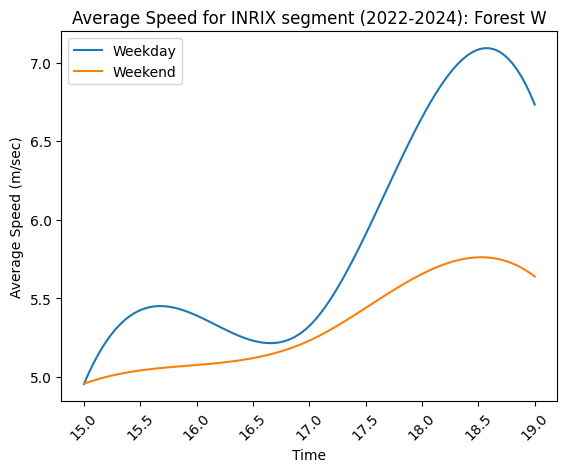

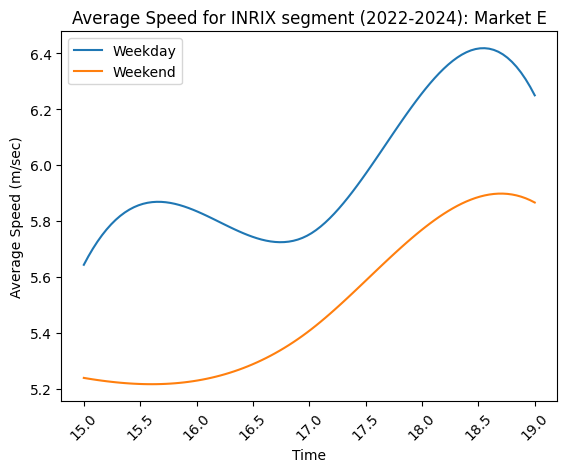

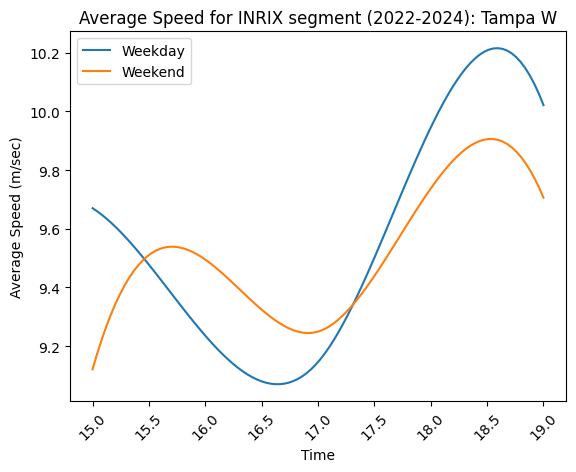

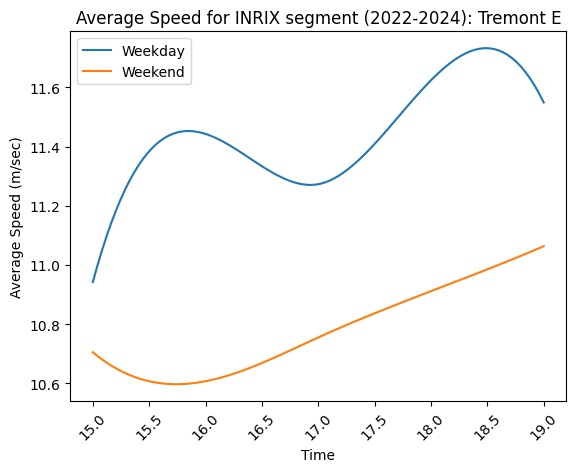

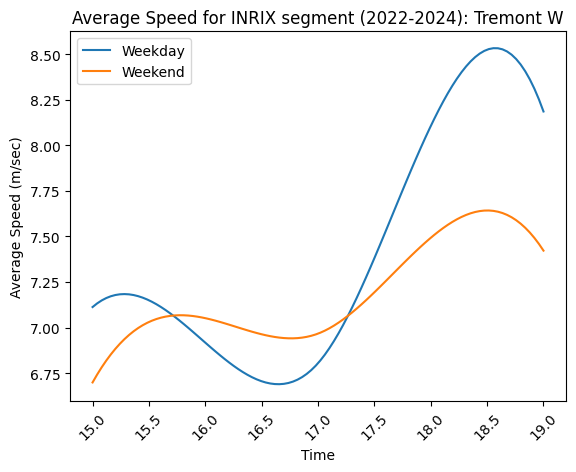

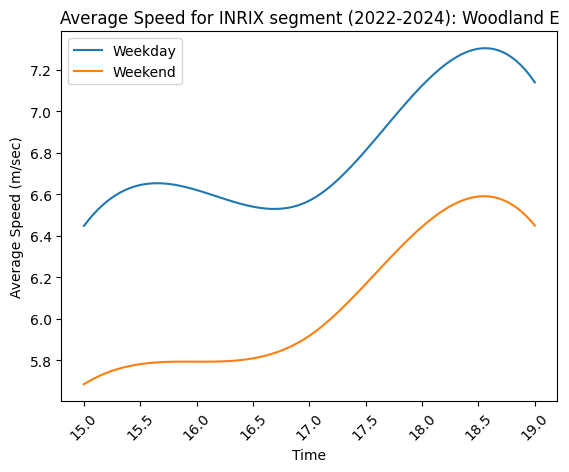

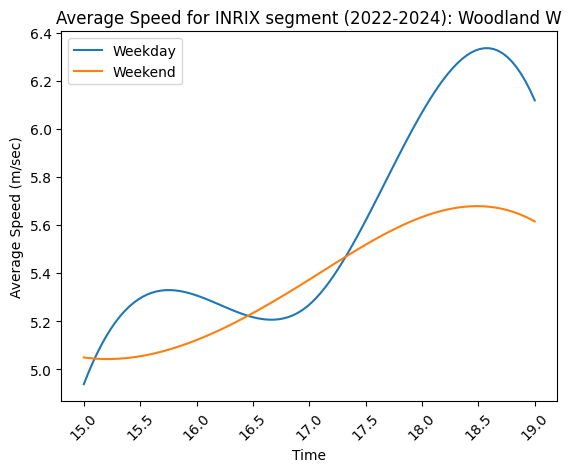

In [349]:
# speed meter per sec. 
grouped_averages['timestamp'] = grouped_averages['timestamp'].astype(str)


for intersection, group_data in grouped_averages.groupby('intersection'):
    fig, ax = plt.subplots()
    for day_type, data in group_data.groupby('day_type'):
        # Extract hour from string timestamp and convert to numeric
        data['time'] = data['timestamp'].str[:2].astype(float)
        
        # Sort data by 'time' column
        data.sort_values(by='time', inplace=True)
        
        # Drop duplicate 'time' values
        data.drop_duplicates(subset='time', inplace=True)
        
        # Interpolate using cubic spline to get smoother curve
        interpolated_data = data.set_index('time')
        cs = CubicSpline(interpolated_data.index, interpolated_data['speed (m/sec)'])
        x_new = np.linspace(interpolated_data.index.min(), interpolated_data.index.max(), 100) # Increase resolution
        y_new = cs(x_new)
        
        # Plot interpolated data
        ax.plot(x_new, y_new, label=day_type)
        
    ax.set_title(f'Average Speed for INRIX segment (2022-2024): {intersection}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Average Speed (m/sec)')
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()


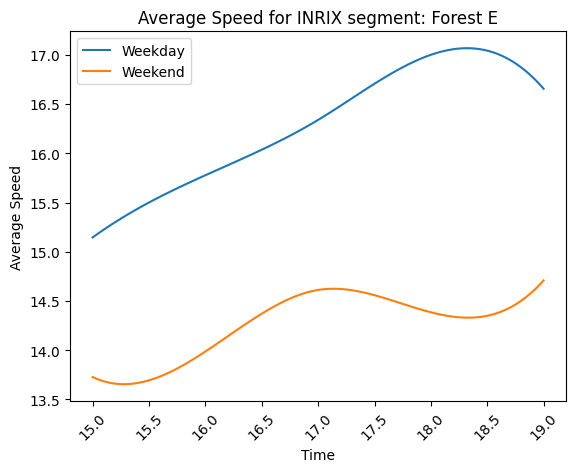

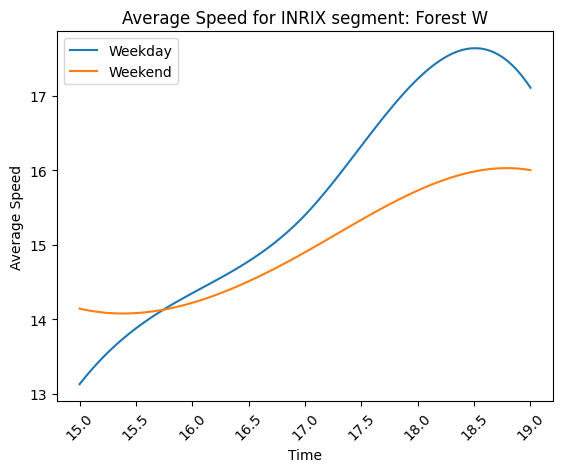

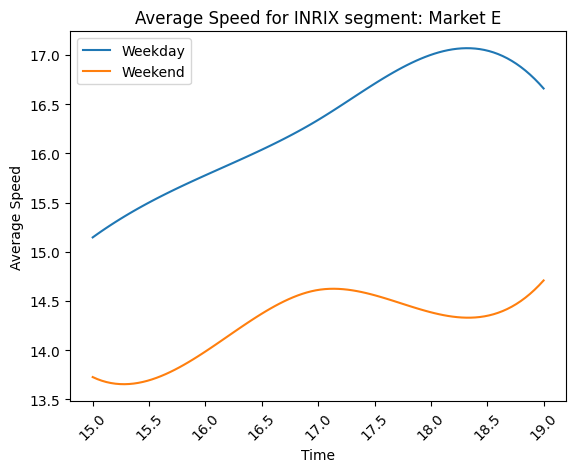

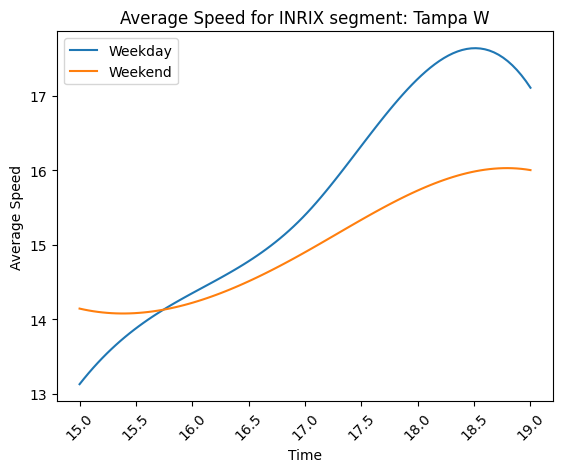

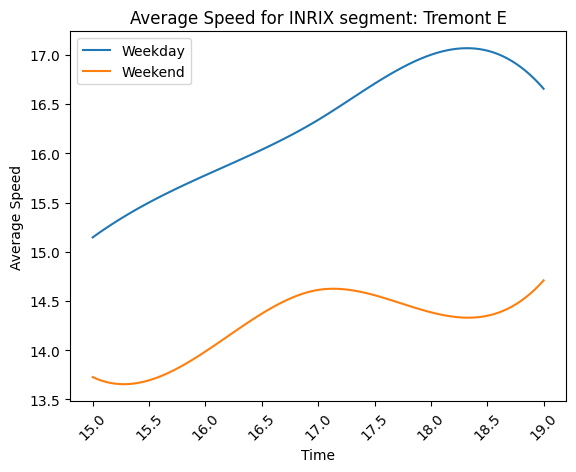

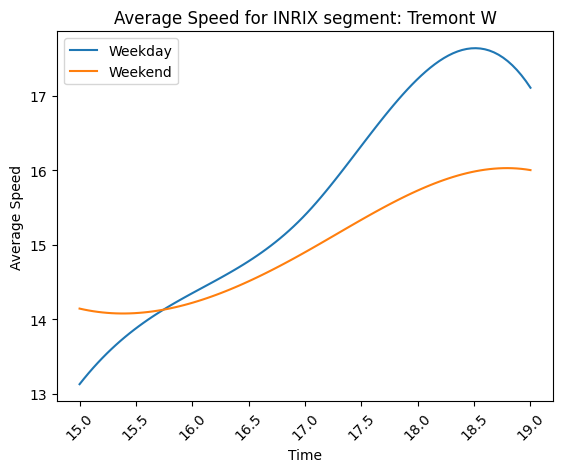

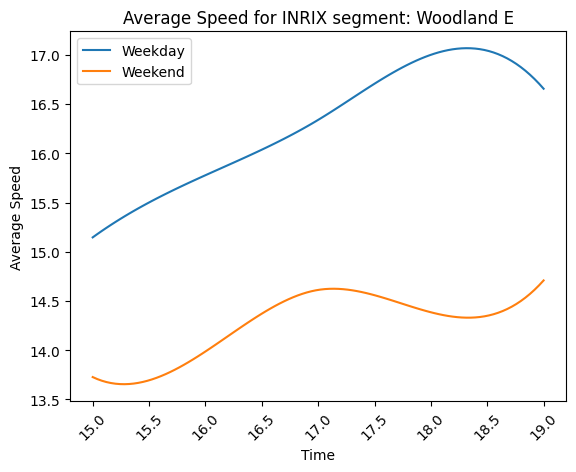

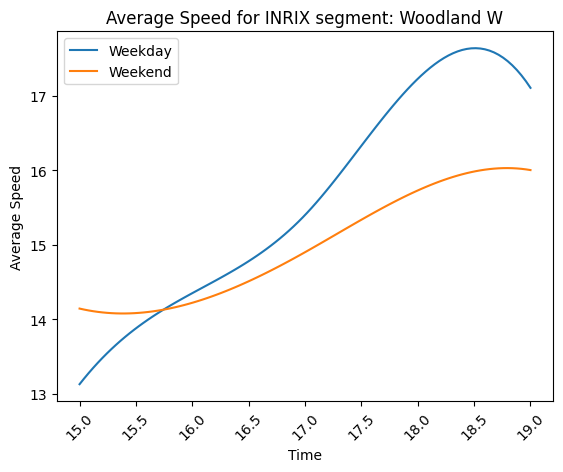

In [155]:
# Speed Mile per hour 
grouped_averages['timestamp'] = grouped_averages['timestamp'].astype(str)


for intersection, group_data in grouped_averages.groupby('intersection'):
    fig, ax = plt.subplots()
    for day_type, data in group_data.groupby('day_type'):
        # Extract hour from string timestamp and convert to numeric
        data['time'] = data['timestamp'].str[:2].astype(float)
        
        # Sort data by 'time' column
        data.sort_values(by='time', inplace=True)
        
        # Drop duplicate 'time' values
        data.drop_duplicates(subset='time', inplace=True)
        
        # Interpolate using cubic spline to get smoother curve
        interpolated_data = data.set_index('time')
        cs = CubicSpline(interpolated_data.index, interpolated_data['average_speed'])
        x_new = np.linspace(interpolated_data.index.min(), interpolated_data.index.max(), 100) # Increase resolution
        y_new = cs(x_new)
        
        # Plot interpolated data
        ax.plot(x_new, y_new, label=day_type)
        
    ax.set_title(f'Average Speed for INRIX segment: {intersection}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Average Speed')
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()

C:\Users\mehdi\AppData\Local\Temp\ipykernel_23148\2532077466.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data = data.set_index('time').interpolate(method='linear')
C:\Users\mehdi\AppData\Local\Temp\ipykernel_23148\2532077466.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data = data.set_index('time').interpolate(method='linear')


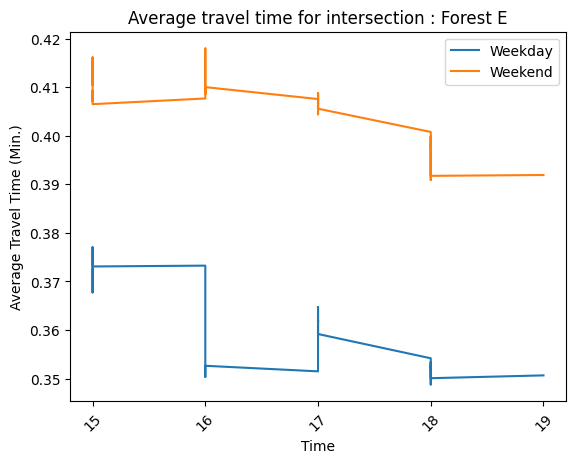

C:\Users\mehdi\AppData\Local\Temp\ipykernel_23148\2532077466.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data = data.set_index('time').interpolate(method='linear')
C:\Users\mehdi\AppData\Local\Temp\ipykernel_23148\2532077466.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data = data.set_index('time').interpolate(method='linear')


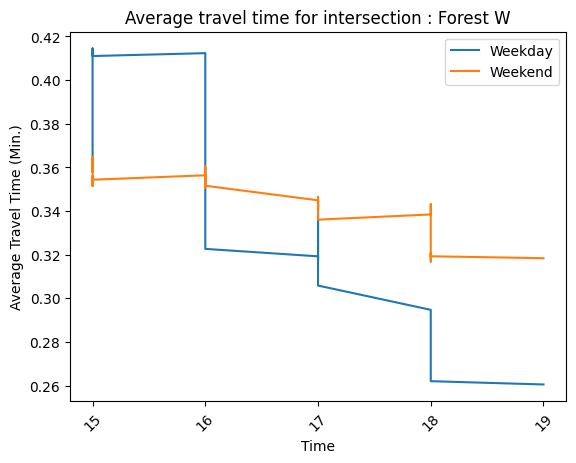

C:\Users\mehdi\AppData\Local\Temp\ipykernel_23148\2532077466.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data = data.set_index('time').interpolate(method='linear')
C:\Users\mehdi\AppData\Local\Temp\ipykernel_23148\2532077466.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data = data.set_index('time').interpolate(method='linear')


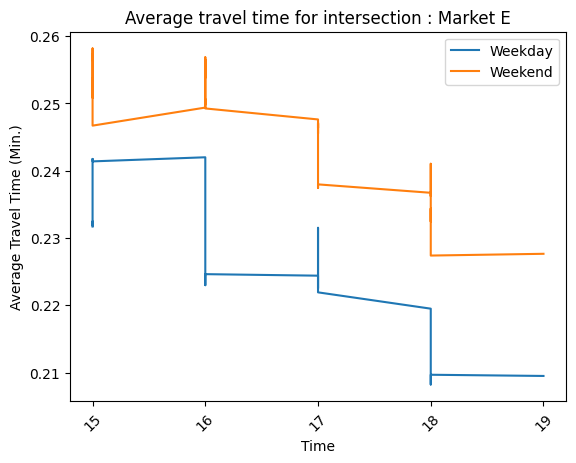

C:\Users\mehdi\AppData\Local\Temp\ipykernel_23148\2532077466.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data = data.set_index('time').interpolate(method='linear')
C:\Users\mehdi\AppData\Local\Temp\ipykernel_23148\2532077466.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data = data.set_index('time').interpolate(method='linear')


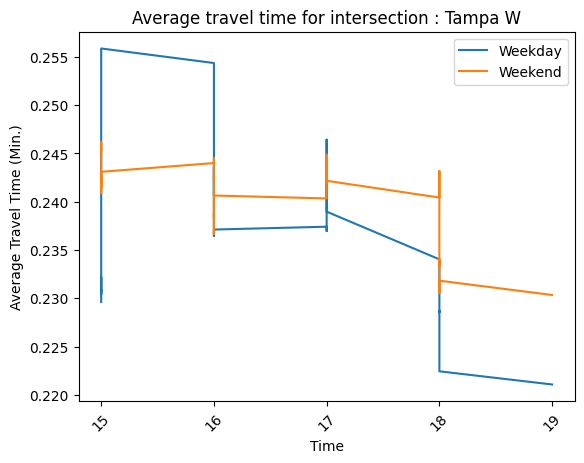

C:\Users\mehdi\AppData\Local\Temp\ipykernel_23148\2532077466.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data = data.set_index('time').interpolate(method='linear')
C:\Users\mehdi\AppData\Local\Temp\ipykernel_23148\2532077466.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data = data.set_index('time').interpolate(method='linear')


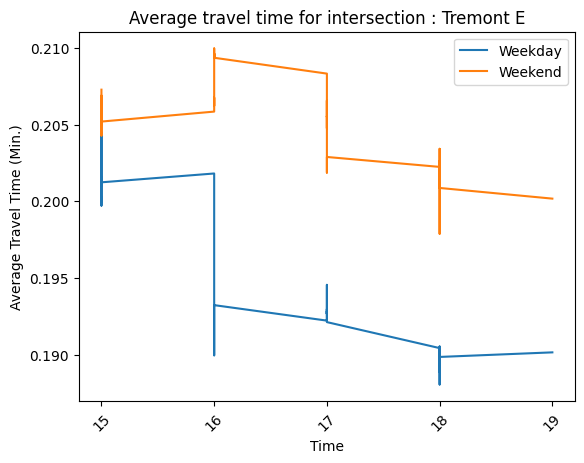

C:\Users\mehdi\AppData\Local\Temp\ipykernel_23148\2532077466.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data = data.set_index('time').interpolate(method='linear')
C:\Users\mehdi\AppData\Local\Temp\ipykernel_23148\2532077466.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data = data.set_index('time').interpolate(method='linear')


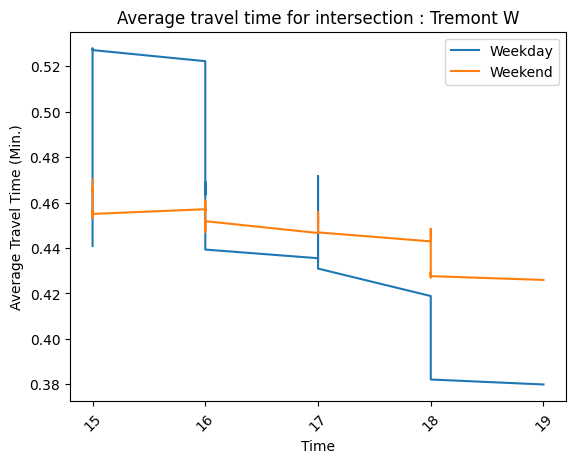

C:\Users\mehdi\AppData\Local\Temp\ipykernel_23148\2532077466.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data = data.set_index('time').interpolate(method='linear')
C:\Users\mehdi\AppData\Local\Temp\ipykernel_23148\2532077466.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data = data.set_index('time').interpolate(method='linear')


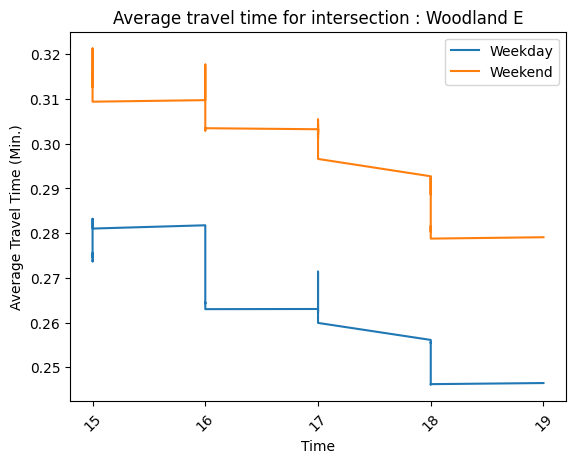

C:\Users\mehdi\AppData\Local\Temp\ipykernel_23148\2532077466.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data = data.set_index('time').interpolate(method='linear')
C:\Users\mehdi\AppData\Local\Temp\ipykernel_23148\2532077466.py:17: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_data = data.set_index('time').interpolate(method='linear')


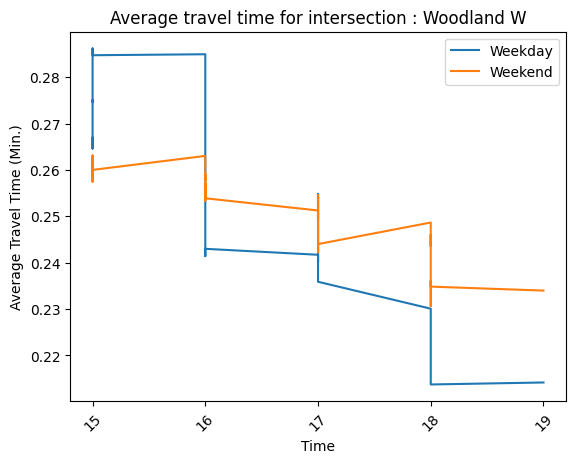

In [79]:

grouped_averages['timestamp'] = grouped_averages['timestamp'].astype(str)

# Plot line charts
for intersection, group_data in grouped_averages.groupby('intersection'):
    fig, ax = plt.subplots()
    for day_type, data in group_data.groupby('day_type'):
        # Extract hour from string timestamp
        data['time'] = data['timestamp'].str[:2]
        
        # Interpolate to get smoother curve
        interpolated_data = data.set_index('time').interpolate(method='linear')
        
        # Plot interpolated data
        ax.plot(interpolated_data.index, interpolated_data['travel_time_minutes'], label=day_type)
        
    ax.set_title(f'Average travel time for intersection : {intersection}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Average Travel Time (Min.)')
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()



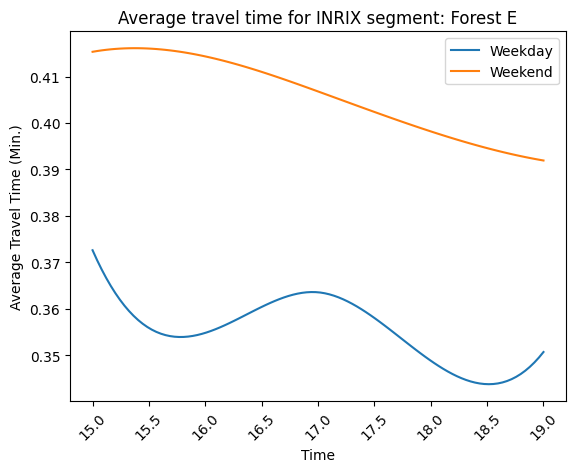

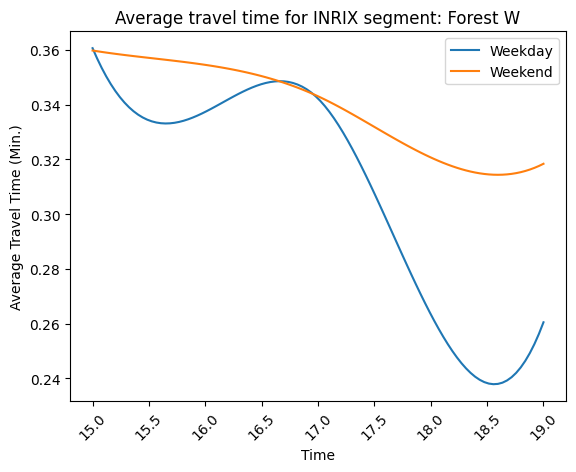

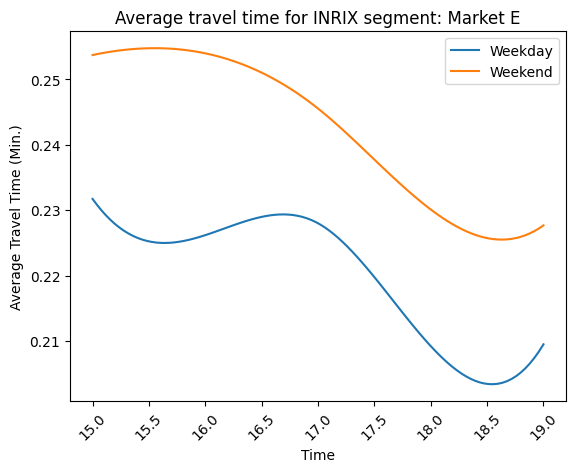

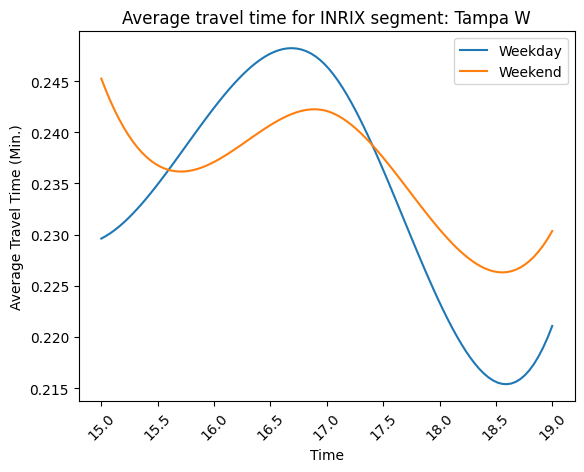

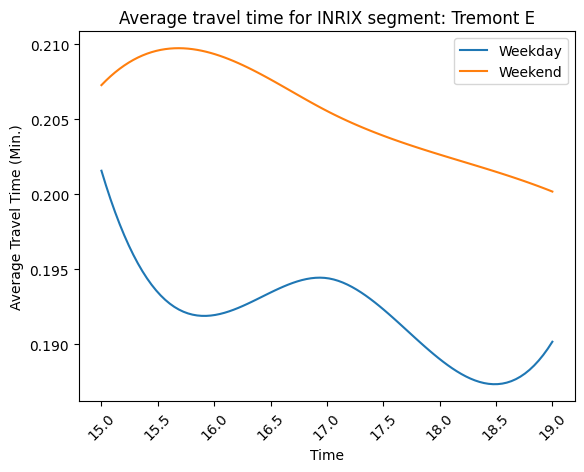

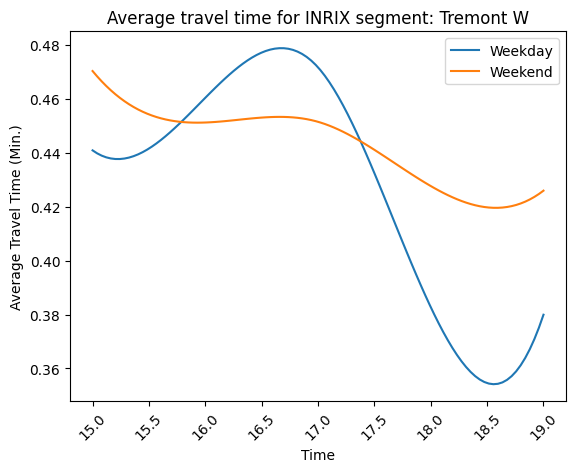

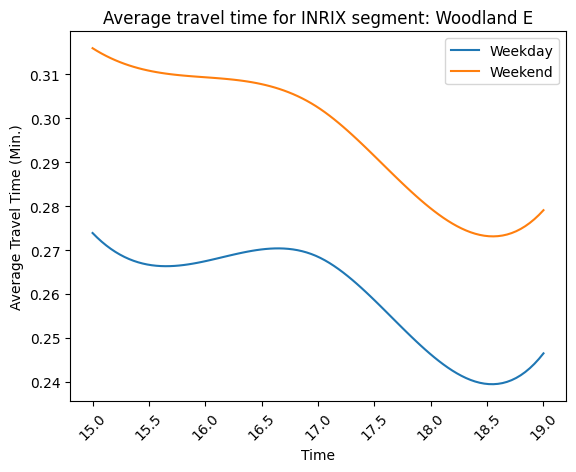

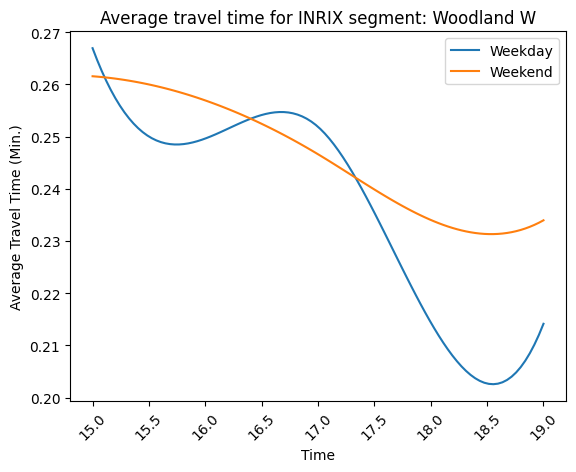

In [80]:

grouped_averages['timestamp'] = grouped_averages['timestamp'].astype(str)

# Plot line charts
for intersection, group_data in grouped_averages.groupby('intersection'):
    fig, ax = plt.subplots()
    for day_type, data in group_data.groupby('day_type'):
        # Extract hour from string timestamp and convert to numeric
        data['time'] = data['timestamp'].str[:2].astype(float)
        
        # Sort data by 'time' column
        data.sort_values(by='time', inplace=True)
        
        # Drop duplicate 'time' values
        data.drop_duplicates(subset='time', inplace=True)
        
        # Interpolate using cubic spline to get smoother curve
        interpolated_data = data.set_index('time')
        cs = CubicSpline(interpolated_data.index, interpolated_data['travel_time_minutes'])
        x_new = np.linspace(interpolated_data.index.min(), interpolated_data.index.max(), 100) # Increase resolution
        y_new = cs(x_new)
        
        # Plot interpolated data
        ax.plot(x_new, y_new, label=day_type)
        
    ax.set_title(f'Average travel time for INRIX segment: {intersection}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Average Travel Time (Min.)')
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()


In [68]:
traci.close()

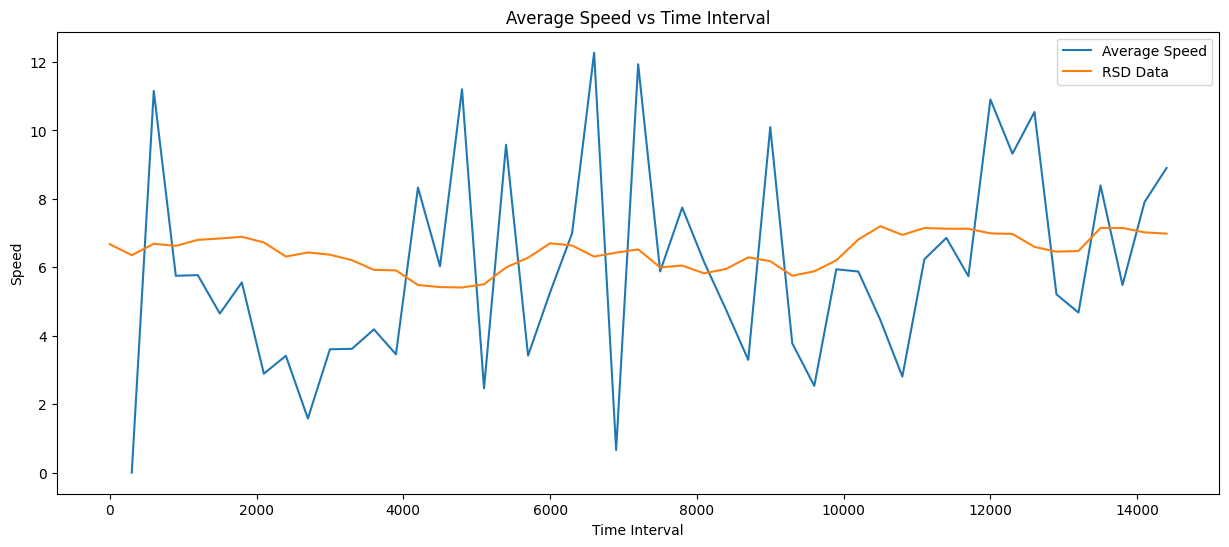

In [69]:

rsd_time = weekend_data_market_e['step_time_sec'].tolist()
rsd_speed = weekend_data_market_e['speed (m/sec)'].tolist()

# Start the TraCI simulation and load the network
traci.start(["sumo", "-c", "C:/Users/mehdi/OneDrive - University of Tennessee/Documents/CUIP Projects/Fraizer street/ITSC/sc1/SUMO_configuration.sumocfg"])

# Set  all vehicle types 
for vehicle_type in traci.vehicletype.getIDList():
        traci.vehicletype.setMaxSpeed(vehicle_type,15.53288232)
        traci.vehicletype.setMaxSpeedLat(vehicle_type,14.00027863 )
        traci.vehicletype.setMinGapLat(vehicle_type,1.38582304 )
        traci.vehicletype.setSpeedFactor(vehicle_type, 1.72713235)
        traci.vehicletype.setTau(vehicle_type,1.82132215  )
        #traci.vehicletype.setImperfection(vehicle_type, .6772)  # Imperfection as sigma, 0.5 as mean
        traci.vehicletype.setAccel(vehicle_type,5.463872 )
        traci.vehicletype.setDecel(vehicle_type,5.14507628 )

    
#Optimized individual:  [          ]
   
    
    
# Run the simulation for the specified time
end_time = 14400
interval = 300
current_time = 0
average_speeds = []

while current_time < end_time:
    # Advance the simulation
    traci.simulationStep(current_time)

    # Get the list of vehicle IDs
    vehicle_ids = traci.vehicle.getIDList()

    # Calculate average speed
    if len(vehicle_ids) > 0:
        speeds = [traci.vehicle.getSpeed(v_id) for v_id in vehicle_ids]
        average_speed = np.mean(speeds)
    else:
        average_speed = 0

    # Store the average speed
    average_speeds.append(average_speed)

    # Increment the current time
    current_time += interval

# End the TraCI simulation
traci.close()

# Generate time intervals
time_intervals = np.arange(interval, end_time + interval, interval)

# Plot the average speed and RSD data
plt.figure(figsize=(15, 6))
plt.plot(time_intervals, average_speeds, label='Average Speed')
plt.plot(rsd_time, rsd_speed, label='RSD Data')
plt.xlabel("Time Interval")
plt.ylabel("Speed")
plt.title("Average Speed vs Time Interval")
plt.legend()
plt.show()



In [41]:
traci.close()

averagae of edge but not good 

gen	nevals	avg    	std     	min    	max    
0  	100   	1.84338	0.310723	1.81215	4.93503
1  	59    	1.81215	2.22045e-16	1.81215	1.81215
2  	58    	1.81215	2.22045e-16	1.81215	1.81215
3  	73    	1.91215	0.994987   	1.81215	11.8121
4  	68    	1.81215	2.22045e-16	1.81215	1.81215
5  	62    	1.91215	0.994987   	1.81215	11.8121
6  	61    	2.01215	1.4        	1.81215	11.8121
7  	51    	2.31215	2.17945    	1.81215	11.8121
8  	66    	2.11215	1.70587    	1.81215	11.8121
9  	52    	1.81215	2.22045e-16	1.81215	1.81215
10 	49    	1.91215	0.994987   	1.81215	11.8121
11 	51    	1.91215	0.994987   	1.81215	11.8121
12 	55    	2.01215	1.4        	1.81215	11.8121
13 	62    	1.81215	2.22045e-16	1.81215	1.81215
14 	63    	1.81215	2.22045e-16	1.81215	1.81215
15 	69    	1.81215	2.22045e-16	1.81215	1.81215
16 	52    	1.91215	0.994987   	1.81215	11.8121
17 	50    	1.91215	0.994987   	1.81215	11.8121
18 	64    	1.81215	2.22045e-16	1.81215	1.81215
19 	55    	1.81215	2.22045e-16	1.81215	1.81215
20 	55    	1.81215	

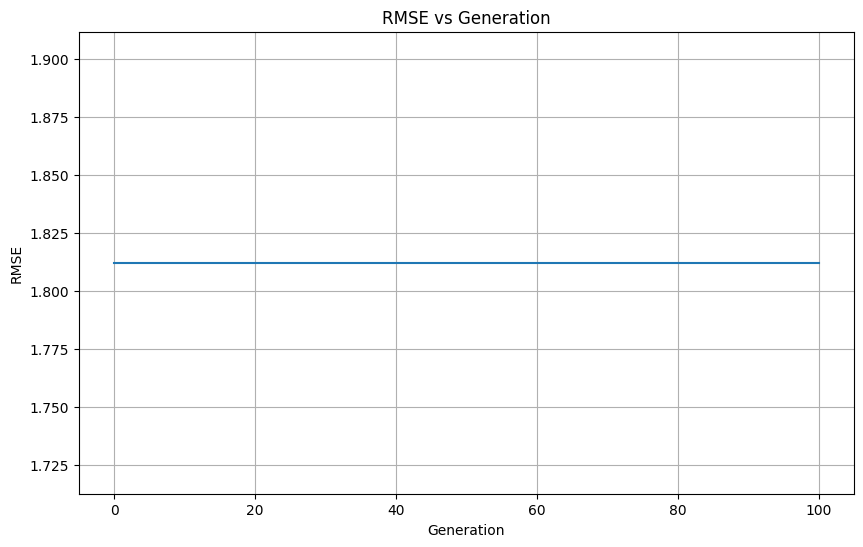

Best individual:  [6.401697536545902, 7.374887512254302, 1.4212727226110373, 1.2959356642646176, 1.0308074310158029, 4.612791121567087, 4.4799430718082816]
Best fitness:  1.8121482422178907


In [42]:

rsd_time = weekday_data_market_e['step_time_sec'].tolist()
rsd_speed = weekday_data_market_e['speed (m/sec)'].tolist()

# Define the ranges for the parameters
MAX_SPEED_RANGE = (5, 18)
MAX_SPEED_LAT_RANGE = (5, 18)
MIN_GAP_LAT_RANGE = (1, 2)
SPEED_FACTOR_RANGE = (1, 2, 0.1)  # range, start, step
TAU_RANGE = (1, 3)
#IMPERFECTION_RANGE = (0.1, .9 , .1)  # range, start, step
ACCEL_RANGE = (3, 6)
DECEL_RANGE = (3, 6)

def fitness_func(individual):
    # Set the vehicle parameters based on the individual
    set_vehicle_parameters(individual)

    # Run the simulation and get average_speeds
    average_speeds_dict = run_simulation(individual)

    # Calculate RMSE between rsd_speed and average_speeds for the desired edges
    desired_edges = ['9040', '9045',  '9052',  '9069',  '9089']
    rsd_speed_array = np.array(rsd_speed)
    rmse_sum = 0

    for edge in desired_edges:
        average_speeds_array = np.array(average_speeds_dict[edge])
        rmse_sum += np.sqrt(np.mean((rsd_speed_array - average_speeds_array) ** 2))

    rmse = rmse_sum / len(desired_edges)

    # Add a penalty term for unrealistic parameter values
    penalty = 0
    if individual[0] < 5 or individual[0] > 18:
        penalty += 10
    if individual[1] < 5 or individual[1] > 18:
        penalty += 10
    if individual[2] < 1 or individual[2] > 2:
        penalty += 10
    if individual[3] < 1 or individual[3] > 2:
        penalty += 10
    if individual[4] < 1 or individual[4] > 3:
        penalty += 10
    if individual[5] < 3 or individual[5] > 6:
        penalty += 10
    if individual[6] < 3 or individual[6] > 6:
        penalty += 10

    return rmse + penalty,

# Function to set vehicle parameters based on the individual
def set_vehicle_parameters(individual):
    for vehicle_type in traci.vehicletype.getIDList():
        traci.vehicletype.setMaxSpeed(vehicle_type, individual[0])
        traci.vehicletype.setMaxSpeedLat(vehicle_type, individual[1])
        traci.vehicletype.setMinGapLat(vehicle_type, individual[2])
        traci.vehicletype.setSpeedFactor(vehicle_type, individual[3])
        traci.vehicletype.setTau(vehicle_type, individual[4])
        #traci.vehicletype.setImperfection(vehicle_type, float(individual[5]))  
        traci.vehicletype.setAccel(vehicle_type, individual[5])
        traci.vehicletype.setDecel(vehicle_type, individual[6])
        

def run_simulation(individual):
    # Set the vehicle parameters based on the individual
    set_vehicle_parameters(individual)

    # Run the simulation for the specified time
    end_time = 14600
    interval = 300
    current_time = 0
    average_speeds = {
        '9040': [],
        '9045': [],
        '9052': [],
        '9069': [],
        '9089': [],
    }

    while current_time < end_time:
        # Advance the simulation
        traci.simulationStep(current_time)

        # Calculate average speed for each edge
        for edge_id in average_speeds.keys():
            vehicle_ids_on_edge = traci.edge.getLastStepVehicleIDs(edge_id)

            if len(vehicle_ids_on_edge) > 0:
                speeds_on_edge = [traci.vehicle.getSpeed(v_id) for v_id in vehicle_ids_on_edge]
                average_speed_on_edge = np.mean(speeds_on_edge)
            else:
                average_speed_on_edge = 0

            average_speeds[edge_id].append(average_speed_on_edge)

        # Increment the current time
        current_time += interval

    return average_speeds

# Start the TraCI simulation and load the network
traci.start(["sumo", "-c", "C:/Users/mehdi/OneDrive - University of Tennessee/Documents/CUIP Projects/Fraizer street/ITSC/sc1/SUMO_configuration.sumocfg"])

# Create the fitness and individual classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Create the toolbox
toolbox = base.Toolbox()

# Define the attribute generators for the individual
toolbox.register("attr_max_speed", random.uniform, MAX_SPEED_RANGE[0], MAX_SPEED_RANGE[1])
toolbox.register("attr_max_speed_lat", random.uniform, MAX_SPEED_LAT_RANGE[0], MAX_SPEED_LAT_RANGE[1])
toolbox.register("attr_min_gap_lat", random.uniform, MIN_GAP_LAT_RANGE[0], MIN_GAP_LAT_RANGE[1])
toolbox.register("attr_speed_factor", random.uniform, SPEED_FACTOR_RANGE[0], SPEED_FACTOR_RANGE[1])
toolbox.register("attr_tau", random.uniform, TAU_RANGE[0], TAU_RANGE[1])
#toolbox.register("attr_imperfection", random.uniform, IMPERFECTION_RANGE[0], IMPERFECTION_RANGE[1])
toolbox.register("attr_accel", random.uniform, ACCEL_RANGE[0], ACCEL_RANGE[1])
toolbox.register("attr_decel", random.uniform, DECEL_RANGE[0], DECEL_RANGE[1])

# Define the structure of an individual
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_max_speed, toolbox.attr_max_speed_lat, toolbox.attr_min_gap_lat,
                  toolbox.attr_speed_factor, toolbox.attr_tau,
                  toolbox.attr_accel, toolbox.attr_decel ), n=1)

# Define the population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Register the fitness function with the toolbox
toolbox.register("evaluate", fitness_func)

# Create the initial population
population = toolbox.population(n=100)

# Run the GA
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Run the GA
pop, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=100,
                                   stats=stats, verbose=True)

# Extract data from the logbook
gen = logbook.select("gen")
fit_mins = logbook.select("min")

# Plot RMSE values over generations
plt.figure(figsize=(10, 6))
plt.plot(gen, fit_mins)
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.title("RMSE vs Generation")
plt.grid(True)
plt.show()

# Print the best individual
best_individual = tools.selBest(pop, 1)[0]
print("Best individual: ", best_individual)
print("Best fitness: ", best_individual.fitness.values[0])


#Best individual:  [12.338146261686605, 13.443991371482392, 1.7388140528596892, 1.8102111582417726, 1.6822862141423611, 5.579336415167104, 3.788641269024848]
#Best fitness:  0.7155577398724536

#Best individual:  [8.412020809229013, 13.617708958850118, 2.4789581450302642, 1.1727664604887642, 1.0400577669349234, 4.676517669509166, 3.195163213469544]
#Best fitness:  1.2295695383513292

#Best individual:  [12.873145883135788, 5.176796818208791, 1.8099705142959774, 2.0151776389124696, 1.0388720997028114, 5.439882720631545, 5.481539203300359]
#Best fitness:  0.8667855623183593

Hybridize with Local Search Algorithms: Similar to gradient-based methods, you can combine the genetic algorithm with local search algorithms, such as hill climbing or simulated annealing. These algorithms can help refine the solutions found by the genetic algorithm by exploring the local neighborhood of promising individuals.
Improve the Fitness Function: To improve the fitness function, you can analyze whether the current fitness function (RMSE between the simulated average speeds and the real-world data) accurately represents the problem you're trying to solve. If necessary, you can modify the fitness function to incorporate additional criteria or constraints that better guide the search process towards desirable solutions.

In [18]:
traci.close()

# final code 

gen	nevals	avg     	std     	min     	max    
0  	50    	0.575964	0.172249	0.551357	1.78171
1  	27    	0.751357	1.4     	0.551357	10.5514
2  	25    	0.551357	0       	0.551357	0.551357
3  	38    	0.551357	0       	0.551357	0.551357
4  	28    	0.551357	0       	0.551357	0.551357
5  	23    	0.751357	1.4     	0.551357	10.5514 
6  	35    	0.751357	1.4     	0.551357	10.5514 
7  	36    	0.551357	0       	0.551357	0.551357
8  	29    	0.751357	1.4     	0.551357	10.5514 
9  	25    	0.551357	0       	0.551357	0.551357
10 	33    	0.751357	1.4     	0.551357	10.5514 
11 	29    	0.551357	0       	0.551357	0.551357
12 	34    	0.551357	0       	0.551357	0.551357
13 	34    	0.551357	0       	0.551357	0.551357
14 	27    	0.751357	1.4     	0.551357	10.5514 
15 	32    	0.751357	1.4     	0.551357	10.5514 
16 	34    	0.551357	0       	0.551357	0.551357
17 	32    	0.551357	0       	0.551357	0.551357
18 	32    	0.751357	1.4     	0.551357	10.5514 
19 	28    	0.551357	0       	0.551357	0.551357
20 	25    	0.551

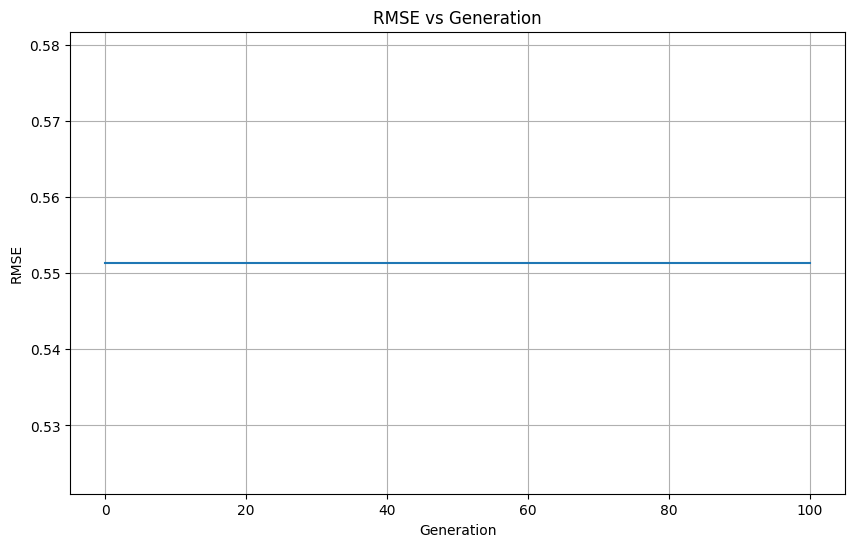

Optimized individual:  [11.85878436  7.38620259  1.89146315  1.26083419  2.11411216  4.51524349
  4.40980023]
Optimized fitness:  0.5513574792292373
Optimized individual:  [11.85878436  7.38620259  1.89146315  1.26083419  2.11411216  4.51524349
  4.40980023]
Optimized fitness:  0.5513574792292373
Optimized individual:  [11.85878436 14.74831055  1.68287139  1.26083419  2.27488979  4.68551866
  4.9480206 ]
Optimized fitness:  0.5513574792292373
Optimized individual:  [11.85878436  7.47397058  1.95091543  1.26083419  2.40420646  4.49078264
  5.00293403]
Optimized fitness:  0.5513574792292373
Optimized individual:  [12.13621737  7.49641109  1.89146315  1.26083419  2.27488979  4.53027974
  5.00293403]
Optimized fitness:  0.5513574792292373
Optimized individual:  [11.85878436  7.47397058  1.89146315  1.26083419  2.27488979  4.51524349
  5.07808559]
Optimized fitness:  0.5513574792292373
Optimized individual:  [11.85878436 14.74831055  1.68287139  1.26083419  2.27488979  4.68551866
  4.948020

In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import traci

# Load the real-world data
rsd_time = weekend_data_market_e['step_time_sec'].tolist()
rsd_speed = weekend_data_market_e['speed (m/sec)'].tolist()

# Define the ranges for the parameters
MAX_SPEED_RANGE = (5, 18)
MAX_SPEED_LAT_RANGE = (5, 18)
MIN_GAP_LAT_RANGE = (1, 2)
SPEED_FACTOR_RANGE = (1, 2, 0.1)  # range, start, step
TAU_RANGE = (1, 3)
ACCEL_RANGE = (3, 6)
DECEL_RANGE = (3, 6)

# Define the fitness function
def fitness_func(individual):
    # Set the vehicle parameters based on the individual
    set_vehicle_parameters(individual)

    # Run the simulation and get average_speeds
    average_speeds = run_simulation(individual)

    # Calculate RMSE between rsd_speed and average_speeds
    rmse = np.sqrt(np.mean((np.array(rsd_speed) - np.array(average_speeds)) ** 2))

    # Add a penalty term for unrealistic parameter values
    penalty = 0
    if individual[0] < 5 or individual[0] > 18:
        penalty += 10
    if individual[1] < 5 or individual[1] > 18:
        penalty += 10
    if individual[2] < 1 or individual[2] > 2:
        penalty += 10
    if individual[3] < 1 or individual[3] > 2:
        penalty += 10
    if individual[4] < 1 or individual[4] > 3:
        penalty += 10
    if individual[5] < 3 or individual[5] > 6:
        penalty += 10
    if individual[6] < 3 or individual[6] > 6:
        penalty += 10
    

    return rmse + penalty,  # Minimize the RMSE with penalty

# Function to set vehicle parameters based on the individual
def set_vehicle_parameters(individual):
    for vehicle_type in traci.vehicletype.getIDList():
        traci.vehicletype.setMaxSpeed(vehicle_type, individual[0])
        traci.vehicletype.setMaxSpeedLat(vehicle_type, individual[1])
        traci.vehicletype.setMinGapLat(vehicle_type, individual[2])
        traci.vehicletype.setSpeedFactor(vehicle_type, individual[3])
        traci.vehicletype.setTau(vehicle_type, individual[4])
        traci.vehicletype.setAccel(vehicle_type, individual[5])
        traci.vehicletype.setDecel(vehicle_type, individual[6])
        

        

# Function to run the simulation and return average_speeds
def run_simulation(individual):
    # Set the vehicle parameters based on the individual
    set_vehicle_parameters(individual)

    # Run the simulation for the specified time
    end_time = 14600
    interval = 300
    current_time = 0
    average_speeds = []

    while current_time < end_time:
        # Advance the simulation
        traci.simulationStep(current_time)

        # Get the list of vehicle IDs
        vehicle_ids = traci.vehicle.getIDList()

        # Calculate average speed
        if len(vehicle_ids) > 0:
            speeds = [traci.vehicle.getSpeed(v_id) for v_id in vehicle_ids]
            average_speed = np.mean(speeds)
        else:
            average_speed = 0

        # Store the average speed
        average_speeds.append(average_speed)

        # Increment the current time
        current_time += interval

    return average_speeds

# Start the TraCI simulation and load the network
traci.start(["sumo", "-c", "C:/Users/mehdi/OneDrive - University of Tennessee/Documents/CUIP Projects/Fraizer street/ITSC/sc1/SUMO_configuration.sumocfg"])

# Create the fitness and individual classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Create the toolbox
toolbox = base.Toolbox()

# Define the attribute generators for the individual
toolbox.register("attr_max_speed", random.uniform, MAX_SPEED_RANGE[0], MAX_SPEED_RANGE[1])
toolbox.register("attr_max_speed_lat", random.uniform, MAX_SPEED_LAT_RANGE[0], MAX_SPEED_LAT_RANGE[1])
toolbox.register("attr_min_gap_lat", random.uniform, MIN_GAP_LAT_RANGE[0], MIN_GAP_LAT_RANGE[1])
toolbox.register("attr_speed_factor", random.uniform, SPEED_FACTOR_RANGE[0], SPEED_FACTOR_RANGE[1])
toolbox.register("attr_tau", random.uniform, TAU_RANGE[0], TAU_RANGE[1])
toolbox.register("attr_accel", random.uniform, ACCEL_RANGE[0], ACCEL_RANGE[1])
toolbox.register("attr_decel", random.uniform, DECEL_RANGE[0], DECEL_RANGE[1])


# Define the structure of an individual
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_max_speed, toolbox.attr_max_speed_lat, toolbox.attr_min_gap_lat,
                  toolbox.attr_speed_factor, toolbox.attr_tau,
                  toolbox.attr_accel, toolbox.attr_decel), n=1)

# Define the population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Register the fitness function with the toolbox
toolbox.register("evaluate", fitness_func)

# Create the initial population
population = toolbox.population(n=50)

# Run the GA
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Run the GA
pop, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=100,
                                   stats=stats, verbose=True)

# Extract data from the logbook
gen = logbook.select("gen")
fit_mins = logbook.select("min")

# Plot RMSE values over generations
plt.figure(figsize=(10, 6))
plt.plot(gen, fit_mins)
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.title("RMSE vs Generation")
plt.grid(True)
plt.show()

# Take the best individuals from the genetic algorithm
best_individuals = tools.selBest(pop, k=10)

# Hybridize with gradient-based optimization (L-BFGS-B)
from scipy.optimize import minimize

# Define a function to calculate the fitness using the SUMO simulation
def calculate_fitness(individual):
    set_vehicle_parameters(individual)
    average_speeds = run_simulation(individual)
    rmse = np.sqrt(np.mean((np.array(rsd_speed) - np.array(average_speeds)) ** 2))

    # Add a penalty term for unrealistic parameter values
    penalty = 0
    if individual[0] < 5 or individual[0] > 18:
        penalty += 10
    if individual[1] < 5 or individual[1] > 18:
        penalty += 10
    if individual[2] < 1 or individual[2] > 2:
        penalty += 10
    if individual[3] < 1 or individual[3] > 2:
        penalty += 10
    if individual[4] < 1 or individual[4] > 3:
        penalty += 10
    if individual[5] < 3 or individual[5] > 6:
        penalty += 10
    if individual[6] < 3 or individual[6] > 6:
        penalty += 10
    

    return rmse + penalty

# Use gradient descent to further optimize the best individuals
for individual in best_individuals:
    result = minimize(calculate_fitness, individual, method='L-BFGS-B')
    print("Optimized individual: ", result.x)
    print("Optimized fitness: ", result.fun)

    #Optimized individual:  [15.53288232 14.00027863  1.38582304  1.72713235  1.82132215  5.463872  5.14507628]
    #Optimized fitness:  0.5504518971974691

In [23]:
traci.close()

In [24]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import traci

# Load the real-world data
rsd_time = weekday_data_market_e['step_time_sec'].tolist()
rsd_speed = weekday_data_market_e['speed (m/sec)'].tolist()

# Define the ranges for the parameters
MAX_SPEED_RANGE = (5, 18)
MAX_SPEED_LAT_RANGE = (5, 18)
MIN_GAP_LAT_RANGE = (1, 2)
SPEED_FACTOR_RANGE = (1, 2, 0.1)  # range, start, step
TAU_RANGE = (1, 3)
ACCEL_RANGE = (3, 6)
DECEL_RANGE = (3, 6)

# Define the fitness function
def fitness_func(individual):
    # Set the vehicle parameters based on the individual
    set_vehicle_parameters(individual)

    # Run the simulation and get average_speeds
    average_speeds = run_simulation(individual)

    # Calculate MAPE between rsd_speed and average_speeds
    mape = np.mean(np.abs((np.array(rsd_speed) - np.array(average_speeds)) / np.array(rsd_speed))) * 100

    # Add a penalty term for unrealistic parameter values
    penalty = 0
    if individual[0] < 5 or individual[0] > 18:
        penalty += 10
    if individual[1] < 5 or individual[1] > 18:
        penalty += 10
    if individual[2] < 1 or individual[2] > 2:
        penalty += 10
    if individual[3] < 1 or individual[3] > 2:
        penalty += 10
    if individual[4] < 1 or individual[4] > 3:
        penalty += 10
    if individual[5] < 3 or individual[5] > 6:
        penalty += 10
    if individual[6] < 3 or individual[6] > 6:
        penalty += 10

    return mape + penalty,  # Minimize the MAPE with penalty

# Function to set vehicle parameters based on the individual
def set_vehicle_parameters(individual):
    for vehicle_type in traci.vehicletype.getIDList():
        traci.vehicletype.setMaxSpeed(vehicle_type, individual[0])
        traci.vehicletype.setMaxSpeedLat(vehicle_type, individual[1])
        traci.vehicletype.setMinGapLat(vehicle_type, individual[2])
        traci.vehicletype.setSpeedFactor(vehicle_type, individual[3])
        traci.vehicletype.setTau(vehicle_type, individual[4])
        traci.vehicletype.setAccel(vehicle_type, individual[5])
        traci.vehicletype.setDecel(vehicle_type, individual[6])

# Function to run the simulation and return average_speeds
def run_simulation(individual):
    # Set the vehicle parameters based on the individual
    set_vehicle_parameters(individual)

    # Run the simulation for the specified time
    end_time = 14600
    interval = 300
    current_time = 0
    average_speeds = []

    while current_time < end_time:
        # Advance the simulation
        traci.simulationStep(current_time)

        # Get the list of vehicle IDs
        vehicle_ids = traci.vehicle.getIDList()

        # Calculate average speed
        if len(vehicle_ids) > 0:
            speeds = [traci.vehicle.getSpeed(v_id) for v_id in vehicle_ids]
            average_speed = np.mean(speeds)
        else:
            average_speed = 0

        # Store the average speed
        average_speeds.append(average_speed)

        # Increment the current time
        current_time += interval

    return average_speeds

# Start the TraCI simulation and load the network
traci.start(["sumo", "-c", "C:/Users/mehdi/OneDrive - University of Tennessee/Documents/CUIP Projects/Fraizer street/ITSC/sc1/SUMO_configuration.sumocfg"])

# Create the fitness and individual classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Create the toolbox
toolbox = base.Toolbox()

# Define the attribute generators for the individual
toolbox.register("attr_max_speed", random.uniform, MAX_SPEED_RANGE[0], MAX_SPEED_RANGE[1])
toolbox.register("attr_max_speed_lat", random.uniform, MAX_SPEED_LAT_RANGE[0], MAX_SPEED_LAT_RANGE[1])
toolbox.register("attr_min_gap_lat", random.uniform, MIN_GAP_LAT_RANGE[0], MIN_GAP_LAT_RANGE[1])
toolbox.register("attr_speed_factor", random.uniform, SPEED_FACTOR_RANGE[0], SPEED_FACTOR_RANGE[1])
toolbox.register("attr_tau", random.uniform, TAU_RANGE[0], TAU_RANGE[1])
toolbox.register("attr_accel", random.uniform, ACCEL_RANGE[0], ACCEL_RANGE[1])
toolbox.register("attr_decel", random.uniform, DECEL_RANGE[0], DECEL_RANGE[1])

# Define the structure of an individual
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_max_speed, toolbox.attr_max_speed_lat, toolbox.attr_min_gap_lat,
                  toolbox.attr_speed_factor, toolbox.attr_tau,
                  toolbox.attr_accel, toolbox.attr_decel), n=1)

# Define the population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Register the fitness function with the toolbox
toolbox.register("evaluate", fitness_func)

# Create the initial population
population = toolbox.population(n=50)

# Run the GA
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Run the GA
pop, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=100,
                                   stats=stats, verbose=True)

# Extract data from the logbook
gen = logbook.select("gen")
fit_mins = logbook.select("min")

# Plot MAPE values over generations
plt.figure(figsize=(10, 6))
plt.plot(gen, fit_mins)
plt.xlabel("Generation")
plt.ylabel("MAPE")
plt.title("MAPE vs Generation")
plt.grid(True)
plt.show()

# Take the best individuals from the genetic algorithm
best_individuals = tools.selBest(pop, k=10)

# Hybridize with gradient-based optimization (L-BFGS-B)
from scipy.optimize import minimize

# Define a function to calculate the fitness using the SUMO simulation
def calculate_fitness(individual):
    set_vehicle_parameters(individual)
    average_speeds = run_simulation(individual)
    mape = np.mean(np.abs((np.array(rsd_speed) - np.array(average_speeds)) / np.array(rsd_speed))) * 100

    # Add a penalty term for unrealistic parameter values
    penalty = 0
    if individual[0] < 5 or individual[0] > 18:
        penalty += 10
    if individual[1] < 5 or individual[1] > 18:
        penalty += 10
    if individual[2] < 1 or individual[2] > 2:
        penalty += 10
    if individual[3] < 1 or individual[3] > 2:
        penalty += 10
    if individual[4] < 1 or individual[4] > 3:
        penalty += 10
    if individual[5] < 3 or individual[5] > 6:
        penalty += 10
    if individual[6] < 3 or individual[6] > 6:
        penalty += 10

    return mape + penalty

# Use gradient descent to further optimize the best individuals
for individual in best_individuals:
    result = minimize(calculate_fitness, individual, method='L-BFGS-B')
    print("Optimized individual: ", result.x)
    print("Optimized fitness: ", result.fun)

gen	nevals	avg    	std    	min   	max    
0  	50    	53.6772	2.71724	53.289	72.6979
1  	34    	53.489 	1.4    	53.289	63.289 
2  	30    	53.489 	1.4    	53.289	63.289 
3  	34    	53.289 	0      	53.289	53.289 
4  	30    	53.489 	1.4    	53.289	63.289 
5  	30    	53.289 	0      	53.289	53.289 
6  	31    	53.289 	0      	53.289	53.289 
7  	30    	53.289 	0      	53.289	53.289 
8  	29    	53.289 	0      	53.289	53.289 
9  	29    	53.689 	1.95959	53.289	63.289 
10 	33    	53.489 	1.4    	53.289	63.289 
11 	23    	53.289 	0      	53.289	53.289 
12 	25    	53.489 	1.4    	53.289	63.289 
13 	30    	53.489 	1.4    	53.289	63.289 
14 	30    	53.489 	1.4    	53.289	63.289 
15 	32    	53.289 	0      	53.289	53.289 
16 	25    	53.289 	0      	53.289	53.289 
17 	34    	53.289 	0      	53.289	53.289 
18 	34    	53.289 	0      	53.289	53.289 
19 	32    	53.289 	0      	53.289	53.289 
20 	38    	53.289 	0      	53.289	53.289 
21 	35    	53.489 	1.4    	53.289	63.289 


KeyboardInterrupt: 

In [ ]:

rsd_time = weekend_data_market_e['step_time_sec'].tolist()
rsd_speed = weekend_data_market_e['speed (m/sec)'].tolist()

# Define the ranges for the parameters
MAX_SPEED_RANGE = (6, 18)
MAX_SPEED_LAT_RANGE = (6, 18)
MIN_GAP_LAT_RANGE = (0.5, 4)
SPEED_FACTOR_RANGE = (1, 2, 0.1)  # range, start, step
TAU_RANGE = (1, 2)
IMPERFECTION_RANGE = (0.1, .9 , .1)  # range, start, step
ACCEL_RANGE = (3, 6)
DECEL_RANGE = (3, 6)

# Define the fitness function
def fitness_func(individual):
    # Set the vehicle parameters based on the individual
    set_vehicle_parameters(individual)

    # Run the simulation and get average_speeds
    average_speeds = run_simulation(individual)

    # Calculate RMSE between rsd_speed and average_speeds
    rmse = np.sqrt(np.mean((np.array(rsd_speed) - np.array(average_speeds)) ** 2))

    return rmse,  # Minimize the RMSE

# Function to set vehicle parameters based on the individual
def set_vehicle_parameters(individual):
    for vehicle_type in traci.vehicletype.getIDList():
        traci.vehicletype.setMaxSpeed(vehicle_type, individual[0])
        traci.vehicletype.setMaxSpeedLat(vehicle_type, individual[1])
        traci.vehicletype.setMinGapLat(vehicle_type, individual[2])
        traci.vehicletype.setSpeedFactor(vehicle_type, individual[3])
        traci.vehicletype.setTau(vehicle_type, individual[4])
        traci.vehicletype.setImperfection(vehicle_type, float(individual[5]))  
        traci.vehicletype.setAccel(vehicle_type, individual[6])
        traci.vehicletype.setDecel(vehicle_type, individual[7])
        

# Function to run the simulation and return average_speeds
def run_simulation(individual):
    # Set the vehicle parameters based on the individual
    set_vehicle_parameters(individual)

    # Run the simulation for the specified time
    end_time = 14600
    interval = 300
    current_time = 0
    average_speeds = []

    while current_time < end_time:
        # Advance the simulation
        traci.simulationStep(current_time)

        # Get the list of vehicle IDs
        vehicle_ids = traci.vehicle.getIDList()

        # Calculate average speed
        if len(vehicle_ids) > 0:
            speeds = [traci.vehicle.getSpeed(v_id) for v_id in vehicle_ids]
            average_speed = np.mean(speeds)
        else:
            average_speed = 0

        # Store the average speed
        average_speeds.append(average_speed)

        # Increment the current time
        current_time += interval

    return average_speeds

# Start the TraCI simulation and load the network
traci.start(["sumo", "-c", "C:/Users/mehdi/OneDrive - University of Tennessee/Documents/CUIP Projects/Fraizer street/ITSC/sc1/SUMO_configuration.sumocfg"])

# Create the fitness and individual classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Create the toolbox
toolbox = base.Toolbox()

# Define the attribute generators for the individual
toolbox.register("attr_max_speed", random.uniform, MAX_SPEED_RANGE[0], MAX_SPEED_RANGE[1])
toolbox.register("attr_max_speed_lat", random.uniform, MAX_SPEED_LAT_RANGE[0], MAX_SPEED_LAT_RANGE[1])
toolbox.register("attr_min_gap_lat", random.uniform, MIN_GAP_LAT_RANGE[0], MIN_GAP_LAT_RANGE[1])
toolbox.register("attr_speed_factor", random.uniform, SPEED_FACTOR_RANGE[0], SPEED_FACTOR_RANGE[1])
toolbox.register("attr_tau", random.uniform, TAU_RANGE[0], TAU_RANGE[1])
toolbox.register("attr_imperfection", random.uniform, IMPERFECTION_RANGE[0], IMPERFECTION_RANGE[1])
toolbox.register("attr_accel", random.uniform, ACCEL_RANGE[0], ACCEL_RANGE[1])
toolbox.register("attr_decel", random.uniform, DECEL_RANGE[0], DECEL_RANGE[1])

# Define the structure of an individual
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_max_speed, toolbox.attr_max_speed_lat, toolbox.attr_min_gap_lat,
                  toolbox.attr_speed_factor, toolbox.attr_tau, toolbox.attr_imperfection,
                  toolbox.attr_accel, toolbox.attr_decel ), n=1)

# Define the population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Register the fitness function with the toolbox
toolbox.register("evaluate", fitness_func)

# Create the initial population
population = toolbox.population(n=50)

# Run the GA
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=100,
                                   stats=stats, verbose=True)

# Print the best individual
best_individual = tools.selBest(pop, 1)[0]
print("Best individual: ", best_individual)
print("Best fitness: ", best_individual.fitness.values[0])

# End the TraCI simulation
traci.close()






In [319]:

# Parse the XML file
tree = ET.parse("C:/Users/mehdi/OneDrive - University of Tennessee/Documents/CUIP Projects/Fraizer street/ITSC/sc1/currernt_edge_data.xml")
root = tree.getroot()

# Define a function to extract data from XML elements
def extract_data(interval, element):
    data = {}
    data['interval_begin'] = float(interval.get('begin'))
    data['interval_end'] = float(interval.get('end'))
    data['edge_id'] = element.get('id')
    data['sampledSeconds'] = float(element.get('sampledSeconds', 0))
    data['traveltime'] = float(element.get('traveltime', 0))
    data['overlapTraveltime'] = float(element.get('overlapTraveltime', 0))
    data['density'] = float(element.get('density', 0))
    data['laneDensity'] = float(element.get('laneDensity', 0))
    data['occupancy'] = float(element.get('occupancy', 0))
    data['waitingTime'] = float(element.get('waitingTime', 0))
    data['timeLoss'] = float(element.get('timeLoss', 0))
    data['speed'] = float(element.get('speed', 0))
    data['speedRelative'] = float(element.get('speedRelative', 0))
    data['departed'] = int(element.get('departed', 0))
    data['arrived'] = int(element.get('arrived', 0))
    data['entered'] = int(element.get('entered', 0))
    data['left'] = int(element.get('left', 0))
    data['laneChangedFrom'] = int(element.get('laneChangedFrom', 0))
    data['laneChangedTo'] = int(element.get('laneChangedTo', 0))
    return data

# Extract data from XML elements and create a list of dictionaries
edge_data = []
for interval in root.findall('.//interval'):
    for edge in interval.findall('.//edge'):
        data = extract_data(interval, edge)
        edge_data.append(data)

# Convert the list of dictionaries into a pandas DataFrame
df_edge = pd.DataFrame(edge_data)



In [323]:
edge_data_averages = df_edge.groupby(['interval_end']).agg({'speed': 'mean','occupancy':'sum' }).reset_index()


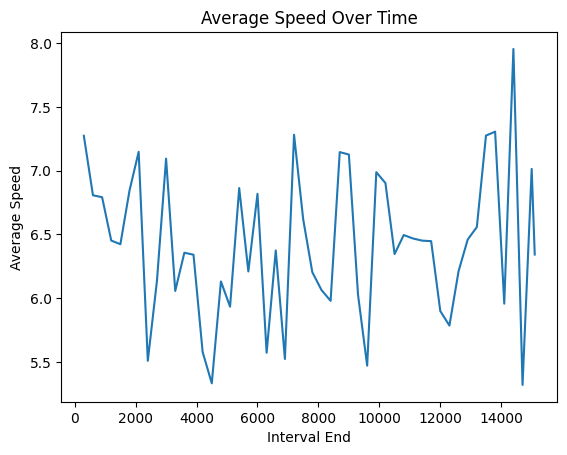

In [325]:
# Plot the data
plt.plot(edge_data_averages['interval_end'], edge_data_averages['speed'])
plt.xlabel('Interval End')
plt.ylabel('Average Speed')
plt.title('Average Speed Over Time')
plt.show()